# Facial Expression Recognition

### 1. Imports

In [16]:
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Sequential

### 2. Converting data sets - ***!!! Only if you want to resize the photos !!!***

In [17]:
img_size = 128

In [18]:
categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [19]:
def convert_data(source_path, save_path, categories):
    for category in categories:
        path_source = os.path.join(source_path, category)
        path_save = os.path.join(save_path, category)

        for img_name in os.listdir(path_source):
            try:
                img_array = cv2.imread(os.path.join(path_source, img_name))
                new_array = cv2.resize(img_array, (img_size, img_size))
                cv2.imwrite(os.path.join(path_save, img_name), new_array)
            except Exception as e:
                print("Error during data preparation")

**2.1 Training set**

In [20]:
train_data_directory_source = "./data/train"
train_data_directory_converted = "./data/train_resized"

In [21]:
convert_data(train_data_directory_source, train_data_directory_converted, categories)

**2.2 Test set**

In [22]:
test_data_directory_source = "./data/test"
test_data_directory_converted = "./data/test_resized"

In [23]:
convert_data(test_data_directory_source, test_data_directory_converted, categories)

### 3. Displaying Images

In [24]:
expression = "happy"

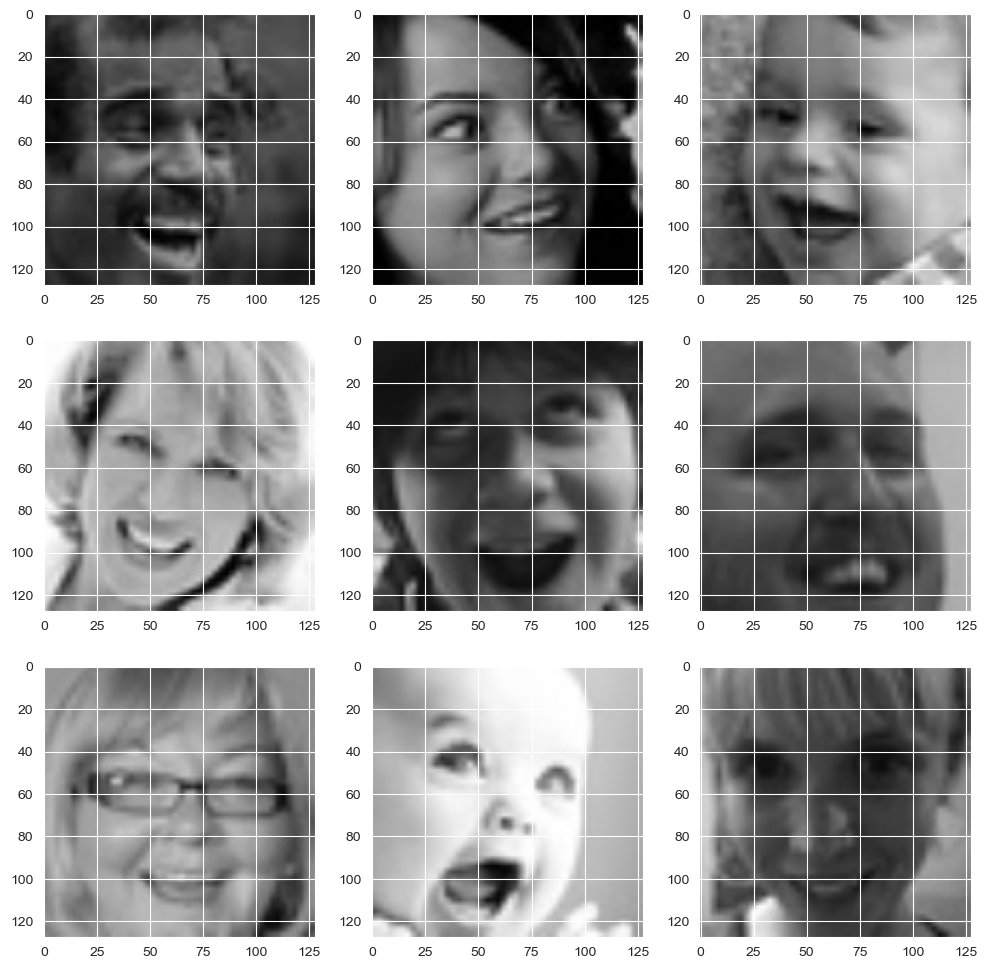

In [25]:
plt.figure(figsize= (12,12))

for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = tf.keras.utils.load_img(train_data_directory_converted + "/" + expression + "/"+
                                  os.listdir(train_data_directory_converted + "/" + expression)[i], target_size=(img_size, img_size))
    plt.imshow(img)
plt.show()

### 4. Data processing

In [26]:
batch_size  = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(train_data_directory_converted,
                                              target_size = (img_size,img_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(test_data_directory_converted,
                                           target_size=(img_size,img_size),
                                           color_mode="grayscale",
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### 5. Model creating

In [27]:
from keras.optimizers import Adam

n_classes = len(categories)

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (img_size,img_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(n_classes, activation='softmax'))

In [28]:
model.compile(optimizer=Adam(lr = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)      

C:\Users\adamd\anaconda3\envs\tf_2.10\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### 6. Model training

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath="./model_final_extended.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=1,
                               restore_best_weights=True
                               )

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learning_rate]

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [31]:
epochs = 48

In [32]:
history = model.fit_generator(generator=train_set,
                              steps_per_epoch=train_set.n//train_set.batch_size,
                              epochs=epochs,
                              validation_data = test_set,
                              validation_steps = test_set.n//test_set.batch_size,
                              callbacks=callbacks_list
                              )

C:\Users\adamd\AppData\Local\Temp\ipykernel_15280\1412514093.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/48
224/224 [==============================] - ETA: 0s - loss: 1.7536 - accuracy: 0.3307
Epoch 1: val_accuracy improved from -inf to 0.27065, saving model to .\model_final_extended.h5
224/224 [==============================] - 152s 651ms/step - loss: 1.7536 - accuracy: 0.3307 - val_loss: 1.8509 - val_accuracy: 0.2706 - lr: 0.0010
Epoch 2/48
224/224 [==============================] - ETA: 0s - loss: 1.4082 - accuracy: 0.4605
Epoch 2: val_accuracy improved from 0.27065 to 0.31836, saving model to .\model_final_extended.h5
224/224 [==============================] - 101s 449ms/step - loss: 1.4082 - accuracy: 0.4605 - val_loss: 1.9649 - val_accuracy: 0.3184 - lr: 0.0010
Epoch 3/48
224/224 [==============================] - ETA: 0s - loss: 1.2314 - accuracy: 0.5312
Epoch 3: val_accuracy improved from 0.31836 to 0.37486, saving model to .\model_final_extended.h5
224/224 [==============================] - 102s 455ms/step - loss: 1.2314 - accuracy: 0.5312 - val_loss: 1.7540 - val_accurac

### 7. Results

**7.1 Loss**

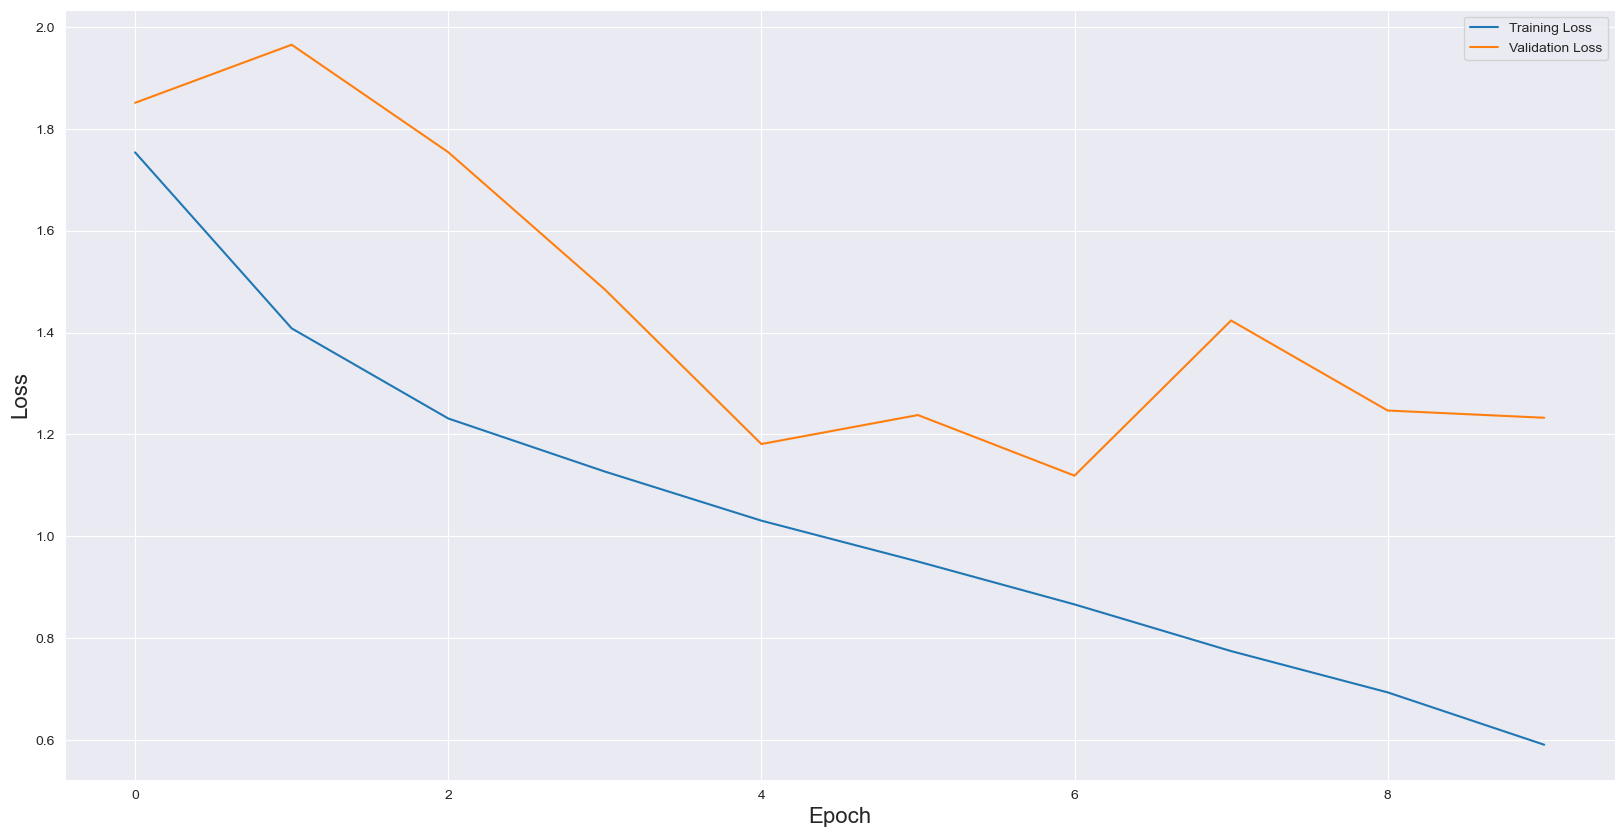

In [36]:
plt.figure(figsize=(20,10))
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

**7.2 Accuracy**

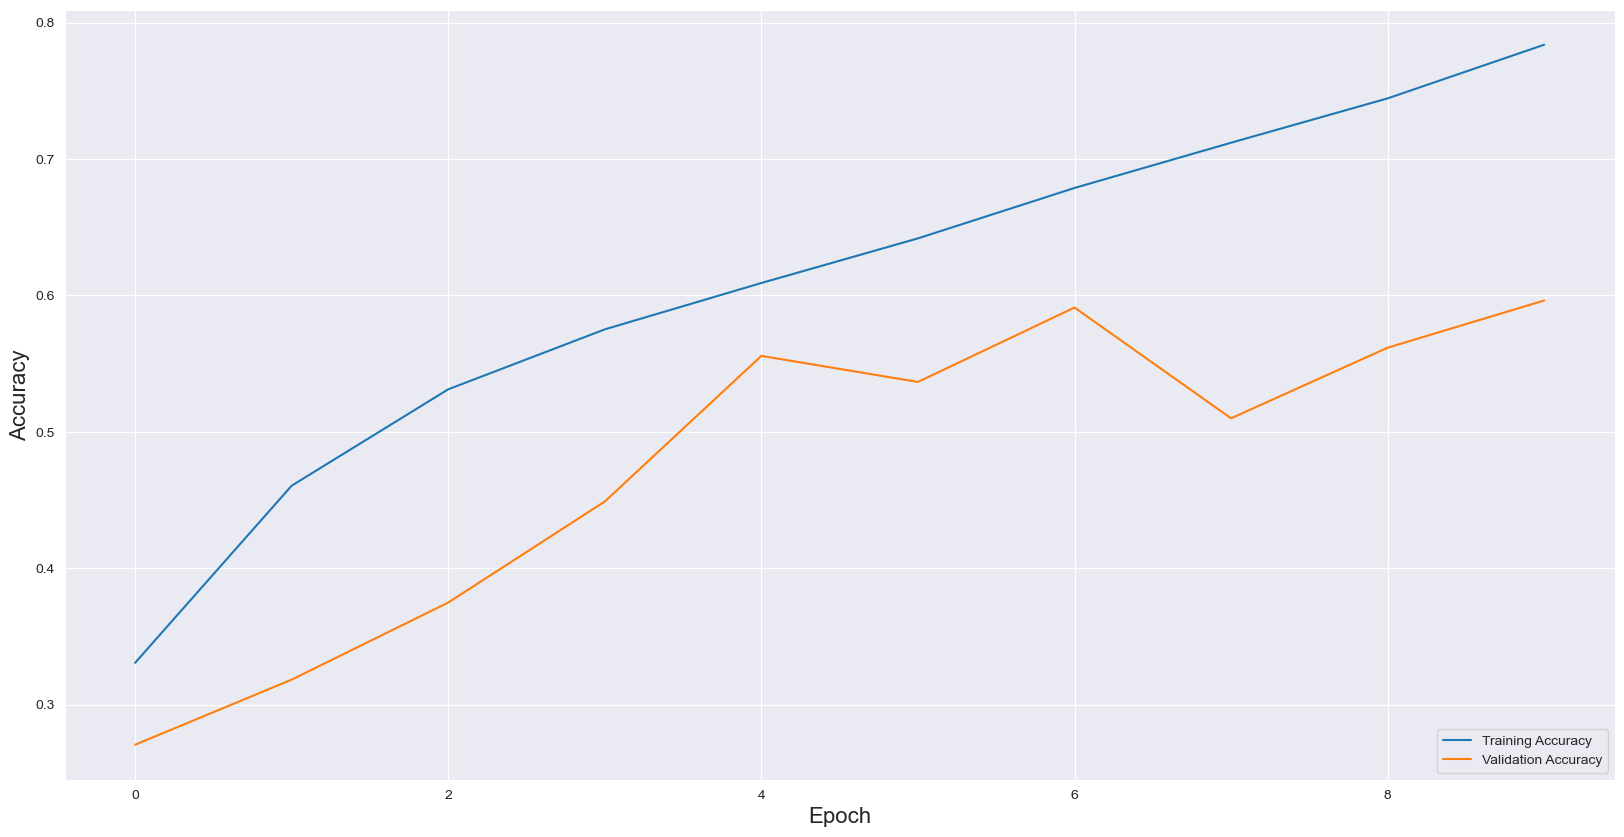

In [37]:
plt.figure(figsize=(20,10))
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()